# Melanoma Detection - Assignment

**Problem statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Step 1 - Importing Necessory Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 2 - Reading the Data

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/MelanomaData/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/MelanomaData/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
# Define some parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Fetching Train and Validation Datasets

train_ds, validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        seed = 123,
        image_size =(img_height,img_width),
        batch_size = batch_size,
        validation_split = 0.2,
        subset = 'both'
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [7]:
# Fetching Test Dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        seed = 123,
        image_size =(img_height,img_width),
        batch_size = batch_size
    )

Found 118 files belonging to 9 classes.


In [8]:
# Listing out all the classes of skin cancer and storing them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Step 3 - Visualising the Data

In [9]:
images_by_label = {}

for batch in train_ds:
    image_batch, label_batch = batch
    for img, lbl in zip(image_batch, label_batch):
        label = lbl.numpy()
        if label not in images_by_label:
            images_by_label[label] = img.numpy()
        if len(images_by_label) == len(class_names):
            break
    if len(images_by_label) == len(class_names):
        break

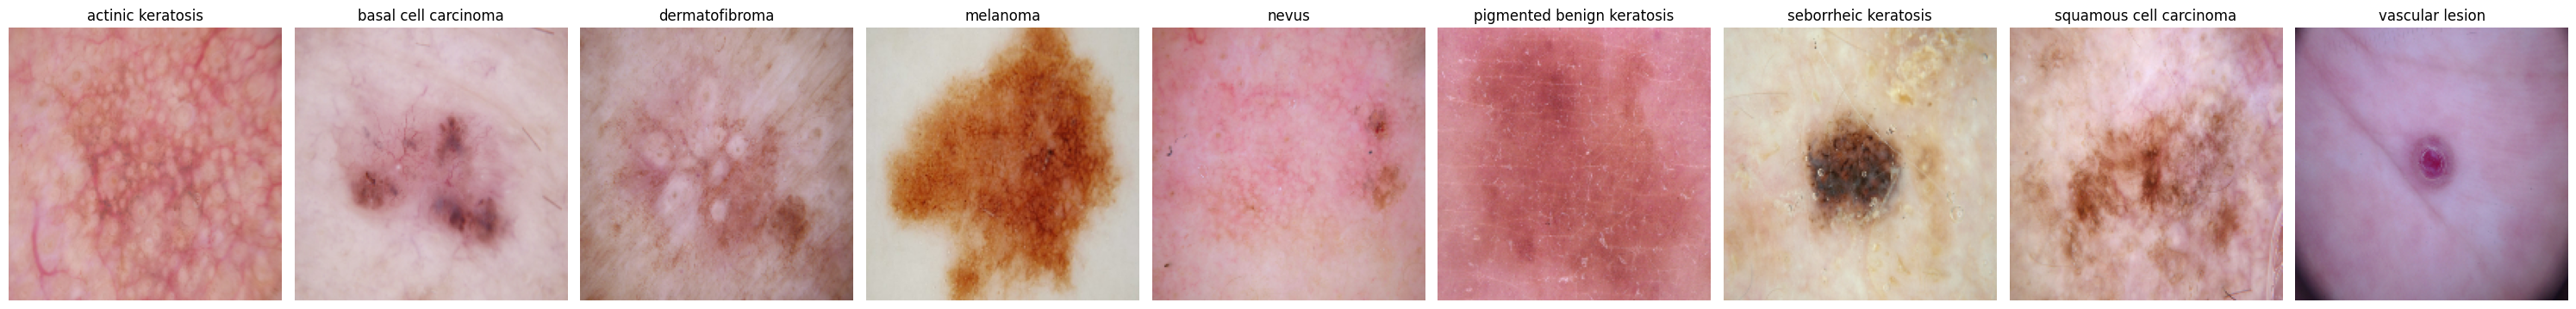

In [10]:
# Plot one image per label
fig, axes = plt.subplots(1, len(class_names), figsize=(30, 15))

for label, ax in images_by_label.items():
    ax = axes[label]
    ax.imshow(images_by_label[label]/255)
    ax.axis('off')
    ax.set_title(class_names[label])

plt.tight_layout()
plt.show()

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Step 4 - Model Creation

In [12]:
# Convert labels to one-hot encoded vectors
def preprocess_image_label(image, label):
    # Ensure the label is cast to an integer type
    label = tf.cast(label, tf.int32)
    # Convert label to one-hot encoded vector
    label = tf.one_hot(label, len(class_names))
    return image, label

# Apply preprocessing to the dataset
train_ds = train_ds.map(preprocess_image_label)
val_ds = val_ds.map(preprocess_image_label)
test_ds = test_ds.map(preprocess_image_label)

In [13]:
# Model Architecture

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, train_ds.element_spec[0].shape[-1])))

model.add(layers.Conv2D(64, (3,3), padding = "same", activation = "relu"))
model.add(layers.Conv2D(64, (3,3), padding = "same", activation = "relu"))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), padding = "same", activation = "relu"))
model.add(layers.Conv2D(128, (3,3), padding = "same", activation = "relu"))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(len(class_names), activation = "softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       147584    
                                                        

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Step 5 - Model Training

In [21]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 99s 2s/step - loss: 2.4841 - accuracy: 0.1836 - val_loss: 2.0150 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 10s 170ms/step - loss: 1.9938 - accuracy: 0.2506 - val_loss: 1.8783 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 10s 171ms/step - loss: 1.7968 - accuracy: 0.3326 - val_loss: 1.6825 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 9s 169ms/step - loss: 1.5953 - accuracy: 0.4275 - val_loss: 1.5728 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 9s 167ms/step - loss: 1.5234 - accuracy: 0.4576 - val_loss: 1.6609 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 9s 167ms/step - loss: 1.4208 - accuracy: 0.5073 - val_loss: 1.4504 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 9s 166ms/step - loss: 1.3427 - accuracy: 0.5379 - val_loss: 1.6324 - val_accuracy: 0.4519
Epoch 

In [22]:
# Function to check accuracy of training and validation datasets
def calculate_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

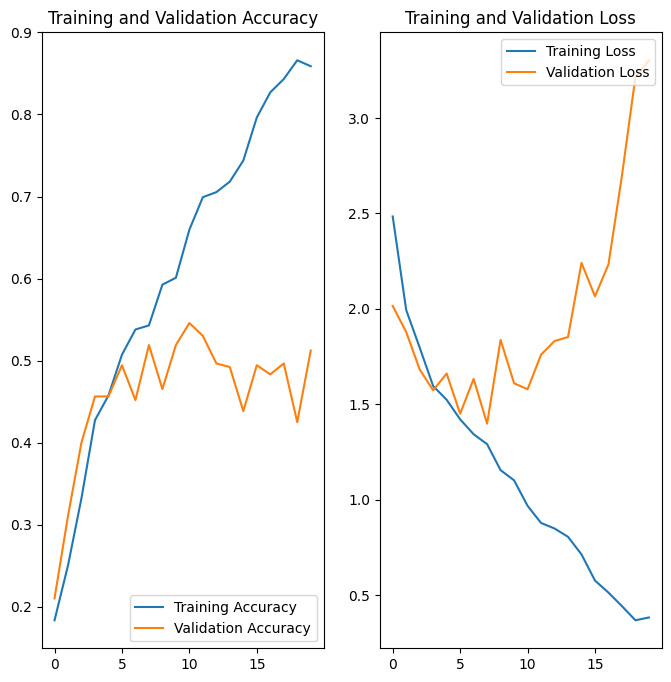

In [23]:
calculate_metrics(history,epochs)

#### **Observations :**
        
- This clearly indicates the presense of overfitting in the model.

- The Training accuracy gradually increases linearly, whereas the validation accuracy plateaus at around 50% accuracy, indicating a clear overfitting.

- As the training epochs progress, the training loss decreases, however, the validation loss exhibits an opposing trend and increases.

- The noticeable difference between the training accuracy and validation accuracy is a clear indication of overfitting, indicating that the model may not generalize well to unseen data.

In [24]:
# Model_1 Architecture with dropouts added

model_1 = Sequential()

model_1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, train_ds.element_spec[0].shape[-1])))

model_1.add(layers.Conv2D(64, (3,3), padding = "same", activation = "relu"))
model_1.add(layers.Conv2D(64, (3,3), padding = "same", activation = "relu"))
model_1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(128, (3,3), padding = "same", activation = "relu"))
model_1.add(layers.Conv2D(128, (3,3), padding = "same", activation = "relu"))
model_1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation = "relu"))
model_1.add(layers.Dropout(0.5))

model_1.add(layers.Dense(len(class_names), activation = "softmax"))


In [25]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 128)       73856     
                                                      

In [26]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
epochs = 20

history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 225ms/step - loss: 2.6879 - accuracy: 0.1925 - val_loss: 2.0336 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 13s 224ms/step - loss: 2.0526 - accuracy: 0.2003 - val_loss: 2.0812 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 12s 218ms/step - loss: 2.0006 - accuracy: 0.2160 - val_loss: 1.8820 - val_accuracy: 0.3579
Epoch 4/20
56/56 [==============================] - 12s 215ms/step - loss: 1.8828 - accuracy: 0.2963 - val_loss: 1.7622 - val_accuracy: 0.3669
Epoch 5/20
56/56 [==============================] - 12s 217ms/step - loss: 1.8063 - accuracy: 0.3153 - val_loss: 1.7635 - val_accuracy: 0.3266
Epoch 6/20
56/56 [==============================] - 12s 219ms/step - loss: 1.7238 - accuracy: 0.3689 - val_loss: 1.7969 - val_accuracy: 0.3579
Epoch 7/20
56/56 [==============================] - 12s 218ms/step - loss: 1.7232 - accuracy: 0.3610 - val_loss: 1.7094 - val_accuracy: 0.3826

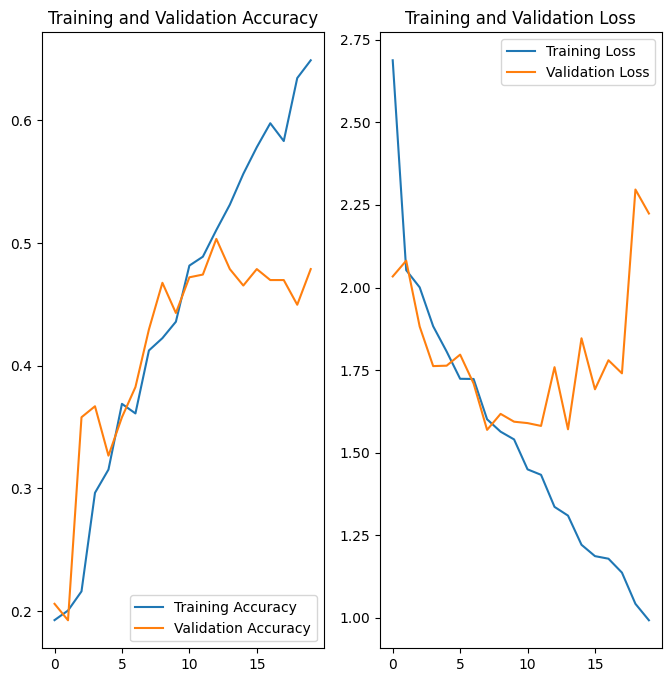

In [28]:
calculate_metrics(history_1,epochs)

#### **Observations :**
        
- Adding of dropout layers has helped to reduce the issue of overfitting.

- Now the training accuracy has decreased from the earlier, but the difference btw training and validation accuracy is still high.


## **Data Augmentation**

Overfitting often happens when the training dataset is limited in size. Data augmentation addresses this issue by creating extra training data through random transformations applied to existing examples, resulting in realistic-looking images. This technique enables the model to encounter a broader range of data variations, enhancing its ability to generalize effectively.

In [29]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

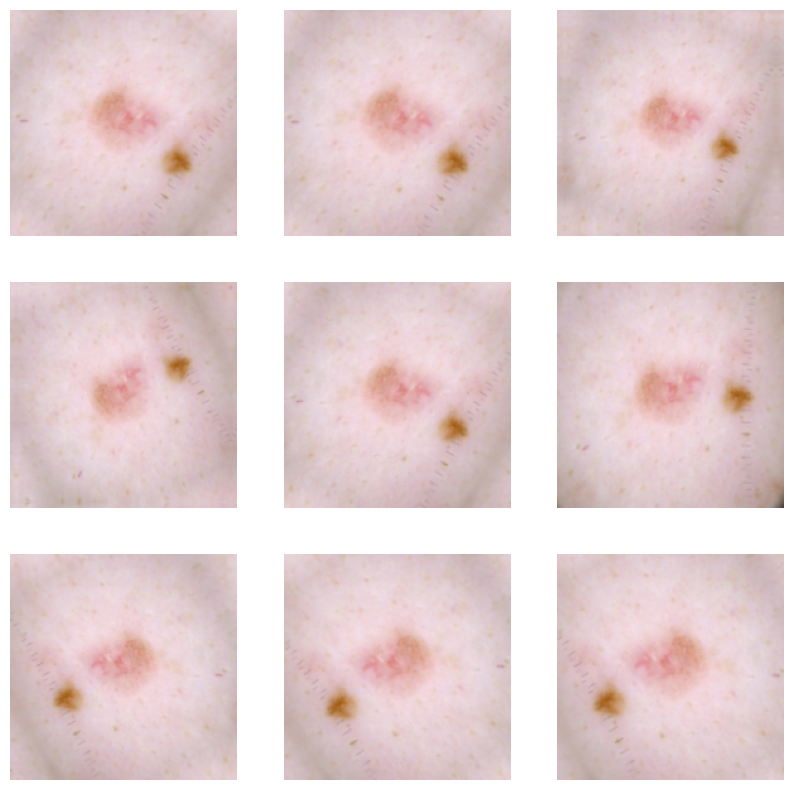

In [30]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## **Model Building & training on the augmented data :**

- Designing a CNN model to accurately classify 9 classes in the dataset.
- Rescaling images to normalize pixel values between (0,1) during preprocessing.
- Selecting an appropriate optimizer and loss function for training the model.
- Training the model for approximately 20 epochs.
- Plotting graphs post-training to assess for signs of overfitting or underfitting.


In [35]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, train_ds.element_spec[0].shape[-1])))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [36]:
# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 128)       73856     
                                                      

In [37]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 173ms/step - loss: 2.1560 - accuracy: 0.2461 - val_loss: 1.9056 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 10s 172ms/step - loss: 1.8006 - accuracy: 0.3354 - val_loss: 1.7060 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 10s 173ms/step - loss: 1.6010 - accuracy: 0.4174 - val_loss: 1.5712 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 10s 172ms/step - loss: 1.5334 - accuracy: 0.4520 - val_loss: 1.4810 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 9s 169ms/step - loss: 1.4837 - accuracy: 0.4609 - val_loss: 1.7480 - val_accuracy: 0.3110
Epoch 6/20
56/56 [==============================] - 9s 167ms/step - loss: 1.4260 - accuracy: 0.4961 - val_loss: 1.3877 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 9s 168ms/step - loss: 1.3608 - accuracy: 0.5246 - val_loss: 1.3994 - val_accuracy: 0.4922
Ep

### Visualizing the results

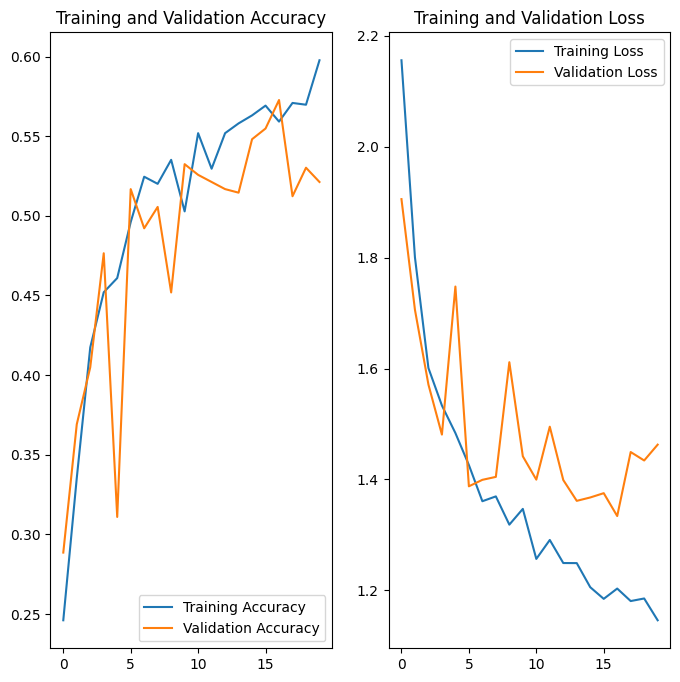

In [38]:
calculate_metrics(history,epochs)

**Inferences:**

- Training accuracy demonstrates a continuous linear ascent over time, whereas validation accuracy initially climbs before plateauing at around 50-55%.

- The training loss steadily diminishes with each epoch, while the validation loss decreases initially but stabilizes afterward.

- Graphical representations reveal a reduced discrepancy between training accuracy and validation accuracy compared to the previous model. The model achieves above 50% accuracy on the validation set.

- A slight gap persists between training and validation accuracy, indicating lingering indications of overfitting.

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

## **Class distribution:**
Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/MelanomaData/Train/acti...,actinic keratosis
1,/content/drive/MyDrive/MelanomaData/Train/acti...,actinic keratosis
2,/content/drive/MyDrive/MelanomaData/Train/acti...,actinic keratosis
3,/content/drive/MyDrive/MelanomaData/Train/acti...,actinic keratosis
4,/content/drive/MyDrive/MelanomaData/Train/acti...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/MelanomaData/Train/vasc...,vascular lesion
2235,/content/drive/MyDrive/MelanomaData/Train/vasc...,vascular lesion
2236,/content/drive/MyDrive/MelanomaData/Train/vasc...,vascular lesion
2237,/content/drive/MyDrive/MelanomaData/Train/vasc...,vascular lesion


In [40]:
## Inspecting the distribution of classes in the data
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

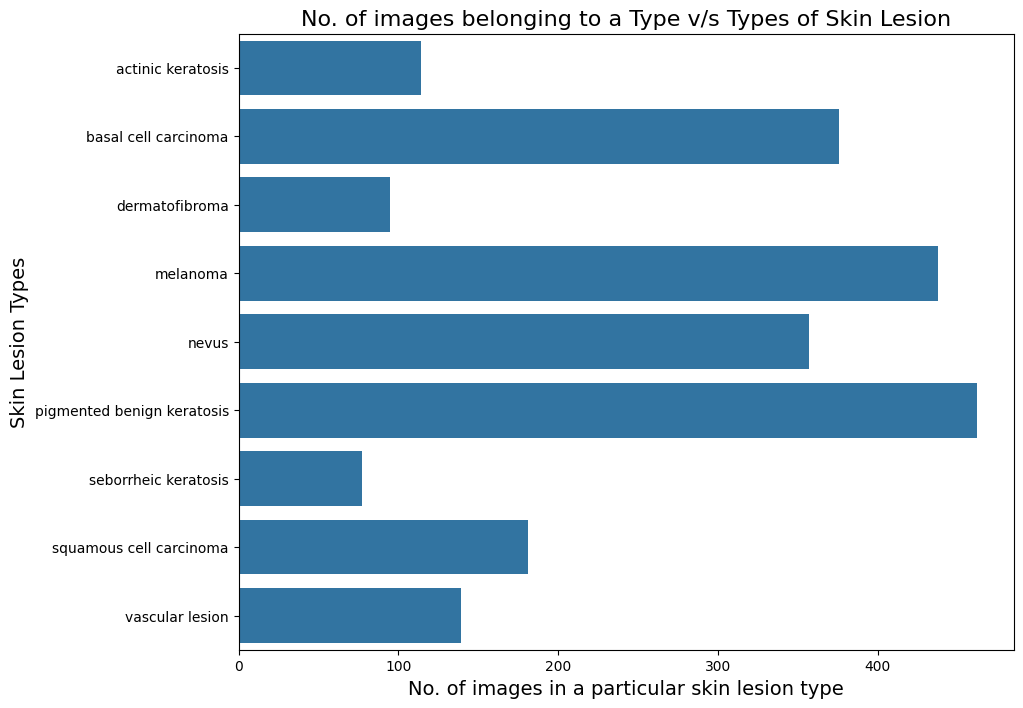

In [41]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data= original_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

**Findings :**
1. Which class has the least number of samples?
- Seborrheic keratosis with 77 samples
2. Which classes dominate the data in terms proportionate number of samples?
- Pigmented benign keratosis with 462 samples


## **Handling class imbalances:**
Rectifing class imbalances present in the training dataset with Augmentor library.

You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78822E4A9330>: 100%|██████████| 500/500 [00:25<00:00, 19.28 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78822C3C8B20>: 100%|██████████| 500/500 [00:27<00:00, 18.04 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7880B26AF7C0>: 100%|██████████| 500/500 [00:21<00:00, 22.83 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78822E542E00>: 100%|██████████| 500/500 [01:43<00:00,  4.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78822E707850>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78822C3C9F90>: 100%|██████████| 500/500 [00:21<00:00, 22.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7880B26AFEB0>: 100%|██████████| 500/500 [00:45<00:00, 11.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7881B05653C0>: 100%|██████████| 500/500 [00:20<00:00, 24.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaData/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78822E74F2E0>: 100%|██████████| 500/500 [00:20<00:00, 24.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_cbc0ccea-cdd5-46ba-a129-e978b4f57d1b.jpg',
 '/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_5b01882d-b603-4756-8da6-91908c03f467.jpg',
 '/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_cc9ebb15-ee4d-4898-af65-b8308ea9b796.jpg',
 '/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_5cf5f1e1-89f3-4ded-825b-eb481f2b204a.jpg',
 '/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_68a7a12b-37f4-4323-a8e4-0af1791a6e51.jpg',
 '/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_f517a7b4-25e3-44e1-88b7-1e293d09c35a.jpg',
 '/content/drive/MyDrive/MelanomaData/Train/actinic keratosis/ou

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [47]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [49]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Creating new dataset**

In [50]:
batch_size = 32
img_height = 180
img_width = 180

In [75]:
# Create a training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               subset='training')


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [76]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## **Model Building & training on the rectified class imbalance data :**
- Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
- Choosing an appropriate optimiser and loss function for model training
- Training the model for ~30 epochs
- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [77]:
# Apply preprocessing to the dataset
train_ds = train_ds.map(preprocess_image_label)
val_ds = val_ds.map(preprocess_image_label)

In [78]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, train_ds.element_spec[0].shape[-1])))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(len(class_names),activation='softmax'))

In [79]:
# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 90, 90, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 45, 45, 128)       0         
 ng2D)                                                

In [80]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 52s 286ms/step - loss: 2.3234 - accuracy: 0.2826 - val_loss: 1.6532 - val_accuracy: 0.3771
Epoch 2/30
169/169 [==============================] - 51s 296ms/step - loss: 1.5478 - accuracy: 0.4114 - val_loss: 1.4961 - val_accuracy: 0.4447
Epoch 3/30
169/169 [==============================] - 49s 281ms/step - loss: 1.4587 - accuracy: 0.4484 - val_loss: 1.3849 - val_accuracy: 0.4729
Epoch 4/30
169/169 [==============================] - 51s 294ms/step - loss: 1.4075 - accuracy: 0.4677 - val_loss: 1.4203 - val_accuracy: 0.4506
Epoch 5/30
169/169 [==============================] - 51s 294ms/step - loss: 1.2915 - accuracy: 0.5119 - val_loss: 1.2607 - val_accuracy: 0.5241
Epoch 6/30
169/169 [==============================] - 48s 276ms/step - loss: 1.2570 - accuracy: 0.5230 - val_loss: 1.2963 - val_accuracy: 0.5026
Epoch 7/30
169/169 [==============================] - 51s 293ms/step - loss: 1.2136 - accuracy: 0.5417 - val_loss: 1.2276 - val_ac

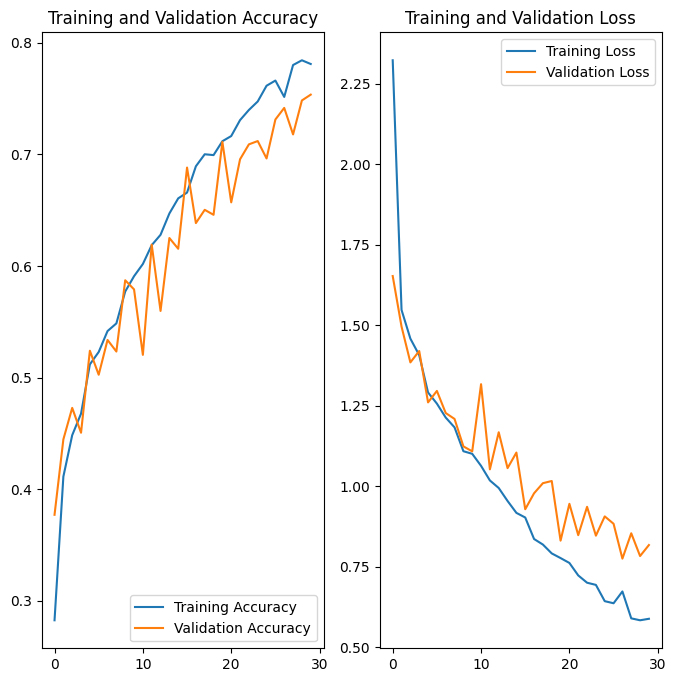

In [81]:
# Visualizing model results
calculate_metrics(history,epochs)

#### **Inference:**

- While training accuracy shows a steady linear increase over time, validation accuracy exhibits a similar upward trend during training.
- Both training loss and validation loss decrease progressively with each epoch.
- The plotted graphs indicate a significantly reduced gap between training accuracy and validation accuracy compared to the previous model, achieving approximately around 75% accuracy on the validation set.
- There is minimal disparity between training and validation accuracy.

**Class rebalancing not only eliminated overfitting but also boosted accuracy from 50% to 75%**

## **Model Prediction**

Predict using test data

1/1 [==============================] - 1s 645ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


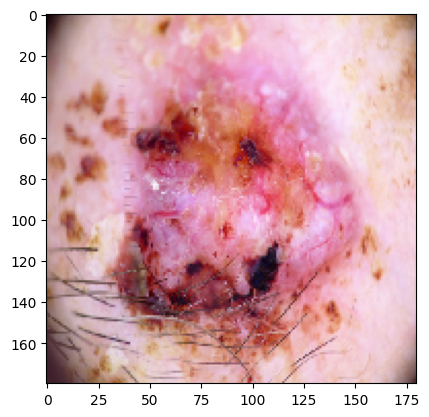

In [82]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)